In [10]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import random
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
from tqdm.notebook import tqdm
from tqdm import tqdm

DATA_PATH = "../data"
VIS_PATH = "../visualisations"
model = spacy.load("en_core_web_trf")

In [3]:
data = pd.read_pickle(DATA_PATH + "/processed/dataset_TENDOC.pkl")
data.head()

,filename,full_text,selected_sections
0,1347 - EN-Annex II - ToR.pdf,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n...,None
1,1415 - EN-Annex II_Terms of Reference_OP_87_20...,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n ...,None
2,1456 - EN-Annex II TOR-FWC-SPServices2016-19.pdf,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n ...,None
3,1507 - EN-Annex II - Terms of Reference.pdf,\n \n\n \n \n \n \n \n \n \n\n \n \n \n \n\n ...,None
4,1556 - EN-Annex II_Terms of Reference_OP_286_2...,\n\n \n \n \n\n \n\n \n\nAnnex II \n\n \n\n ...,None


## Tokenization

In [4]:
def tokenize(sample):
    if not sample:
        return None
    
    tokens = []
    doc = model(sample)
    for token in doc:
        if token.pos_ != "PUNCT":
            token_processed = token.lemma_.lower().strip()
        
            if token_processed not in STOP_WORDS:
                tokens.append(token_processed)        
    return " ".join(tokens)

In [185]:
def filter_tokens(tokenized_text):
    split_text = tokenized_text.split(" ")
    output = []
    for token in split_text:
        if len([char for char in token if char.isdigit()]) == 0:
            output.append(token)
            
    return " ".join(output)

In [75]:
def split_text(text, desired_part_length=100000):
    """
    Splits a text into roughly equal parts of a given length.
    Only splits on whitespace.
    """
    
    length = len(text)
    n_parts = length // desired_part_length
    steps = length // n_parts

    parts = []
    start = 0 
    end = 0
    for _ in range(n_parts - 1):
        end = end + steps
        # make sure to split on whitespace to not mess up tokenization
        for i in range(end, length):
            if text[i] in [" ", "\n"]:
                end = i
                break

        parts.append(text[start:end])
        start = end

    parts.append(text[start:length])
    return parts

In [ ]:
# test tokenization
sample = data["full_text"].iloc[43]
print(sample)
print("="*80)
print(tokenize(sample))

In [81]:
# add a new column to the dataset, namely the tokenized versions of the full_text of the documents
tokenized_full_text = []
for ft in tqdm(data["full_text"]):
    length = len(ft)
    if length > 100000:
        parts = split_text(ft)
        tokenized_parts = [tokenize(part) for part in parts]
        tokenized = "".join(tokenized_parts)
    else:
        tokenized = tokenize(ft)
    tokenized_full_text.append(tokenized)
    
data["full_text tokenized"] = tokenized_full_text
data.to_pickle(DATA_PATH + "/processed/dataset_TENDOC_tokenized.pkl")

100%|██████████████████████████████████████████████████████████████████████████████| 124/124 [2:43:34<00:00, 79.15s/it]


In [195]:
# add another column to the dataset, namely the filtered tokenized full text
filtered_tokens = []
for ft in tqdm(data["full_text tokenized"]):
    filtered_tokens.append(filter_tokens(ft))
    
data["full_text tokenized filtered"] = filtered_tokens

100%|███████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 264.90it/s]


## Preprocess data

In [233]:
%%time
# filter datapoints with invalid or missing descriptions
full_texts = data[data["full_text tokenized filtered"].notna()].reset_index(drop=True)
full_texts = full_texts[full_texts["filename"] != '3034 - EN-Annex II part A - ToR - List of equipment.pdf']
tokenized_full_texts = full_texts["full_text tokenized filtered"]

# vectorize data, that is create matrix of word count per document
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(tokenized_full_texts)

# total word counts
word_freq = [np.sum(data_vectorized.toarray()[:,index]) for index in range(len(vectorizer.get_feature_names()))]

Wall time: 41.6 s


In [93]:
# DELETE THIS
# Save visualisation as html for multiple k's
# for i in range(2, 11):
#     lda = LatentDirichletAllocation(n_components=i, learning_method='online')
#     data_lda = lda.fit_transform(data_vectorized)

#     # apparantly this is bugged in jupyterlab, but works in jupyter notebook
#     plot = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')

#     # export the graph as html
#     pyLDAvis.save_html(plot, VIS_PATH + '/lda_' + str(i) + '_topics.html')

## Find optimal hyperparameters

In [132]:
%%time
log_likelihoods = []
perplexities = []
coherences = []
ks = list(range(2, 50))
for i in tqdm(ks):
    lda = LatentDirichletAllocation(n_components=i, learning_method='online')
    data_lda = lda.fit_transform(data_vectorized.toarray())
    
    coherence = metric_coherence_gensim(
        measure='u_mass',
        topic_word_distrib=lda.components_,
        dtm=data_vectorized.toarray(),
        vocab=np.array(vectorizer.get_feature_names())
    )
    coherences.append(np.mean(coherence))
    
    log_likelihoods.append(lda.score(data_vectorized))
    perplexities.append(lda.perplexity(data_vectorized))

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [08:41<00:00, 10.86s/it]

Wall time: 8min 41s


3 highest log likelihoods: [-3469382.44664311 -3497679.82238095 -3508624.33949664]
Associated k's: [7, 5, 4]


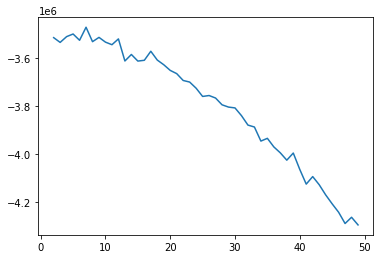

In [133]:
plt.plot(ks, log_likelihoods)

top_n = 3
print(f"{top_n} highest log likelihoods: {np.sort(log_likelihoods)[::-1][:top_n]}")
print(f"Associated k's: {[ks[i] for i in np.argsort(log_likelihoods)[::-1][:top_n]]}")

3 lowest perplexities: [1281.47982002 1358.49876326 1389.51371523]
Associated k's: [7, 5, 4]


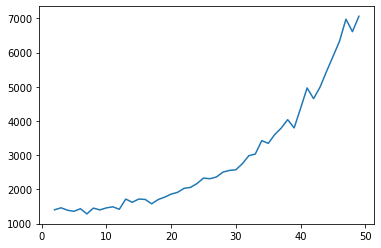

In [134]:
plt.plot(ks, perplexities)

top_n = 3
print(f"{top_n} lowest perplexities: {np.sort(perplexities)[:top_n]}")
print(f"Associated k's: {[ks[i] for i in np.argsort(perplexities)[:top_n]]}")

3 highest cv coherence: [-0.39159302 -0.43326829 -0.4568136 ]
Associated k's: [3, 6, 43]


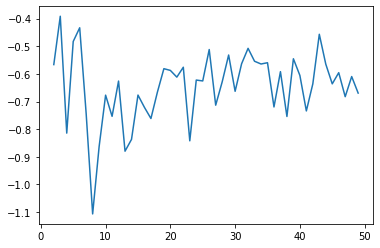

In [135]:
plt.plot(ks, coherences)

top_n = 3
print(f"{top_n} highest cv coherence: {np.sort(coherences)[::-1][:top_n]}")
print(f"Associated k's: {[ks[i] for i in np.argsort(coherences)[::-1][:top_n]]}")

## Optimal model

In [237]:
%%time
# LDA using optimal k
lda = LatentDirichletAllocation(n_components=7, learning_method='online', verbose=1, max_iter=100)
lda.fit(data_vectorized)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of 

In [238]:
# transform data
data_lda = lda.transform(data_vectorized)

#### Save model

In [338]:
import pickle
MODELS_PATH = "../models"

with open(MODELS_PATH + "/scikitLDA10.pkl", "wb") as f:
    pickle.dump(lda, f)

#### Load model

In [6]:
import pickle
MODELS_PATH = "../models"

with open(MODELS_PATH + "/scikitLDA9.pkl", "rb") as f:
    lda = pickle.load(f)

## Visualize topics

In [239]:
plot = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne', sort_topics=False, )

# export the graph as html
# pyLDAvis.save_html(plot, VIS_PATH + '/scikitLDA7_plot.html')

# show plot
plot

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      49.060287 -30.970987       1        1   0.003941
1      13.544554  23.610594       2        1   3.591326
2      19.548477 -89.019653       3        1  45.206266
3     -45.479355 -92.488693       4        1   3.788442
4     -15.967233 -34.438095       5        1  40.257182
5     -80.996124 -37.904793       6        1   3.141848
6     -51.483051  20.144466       7        1   4.010996, topic_info=             Term         Freq        Total Category  logprob  loglift
7709        shall  7027.000000  7027.000000  Default  30.0000  30.0000
3489      frontex  9908.000000  9908.000000  Default  29.0000  29.0000
1765     contract  4512.000000  4512.000000  Default  28.0000  28.0000
4255  information  2238.000000  2238.000000  Default  27.0000  27.0000
2483     document  2209.000000  2209.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2150      deliver   112.037507  1016.392388   Topic7  -5.0723   1.0109
242        agency   117.760446  1397.490162   Topic7  -5.0224   0.7423
8470    technical   113.765524  1666.176288   Topic7  -5.0570   0.5320
5885        order   111.319287  1592.254347   Topic7  -5.0787   0.5556
4982          lot    97.586180  1290.392624   Topic7  -5.2104   0.6342

[571 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
18        5  0.998641         abn
48        2  0.045006  acceptance
48        3  0.358003  acceptance
48        5  0.338569  acceptance
48        6  0.077738  acceptance
...     ...       ...         ...
9507      4  0.897392          ye
9513      4  0.198435         yes
9513      5  0.410715         yes
9513      6  0.387641         yes
9516      3  0.545214     yoghurt

[1187 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

In [9]:
# name topics
topic_names_k7 = {
    1 : 'deployment?',
    2 : 'clothing/uniforms',
    3 : 'presentations/markets',
    4 : 'information systems',
    5 : 'local frontex operations',
    6 : 'software development',
    7 : 'surveillance'
}

topic_names_k9 = {
    1 : 'information systems',
    2 : 'local operational support',
    3 : 'organised events',
    4 : 'border control',
    5 : 'contract',
    6 : 'software development',
    7 : 'surveillance',
    8 : 'ground support/equipment',
    9 : 'clothing/uniforms',
}

topic_names_k11 = {
    1 : 'software development',
    2 : 'travel/location',
    3 : 'local frontex operation',
    4 : 'nautical charts/intranet?',
    5 : 'clothing/uniform',
    6 : 'organised events',
    7 : 'contract',
    8 : 'remote controlled vehicles?',
    9 : 'information systems',
    10 : 'border control',
    11 : 'surveillance',
}

topic_names = topic_names_k9

Document distribution


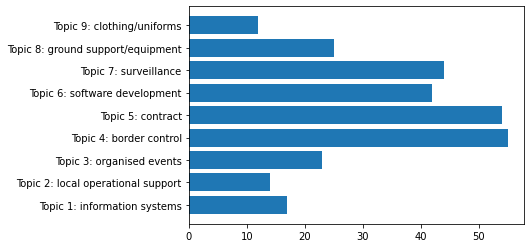

In [10]:
# docments per dominant topic
document_dist = []
for topic_n in range(len(data_lda[0])):
    n_docs = len([i for i, val in enumerate(data_lda) if np.argsort(val)[-1] == topic_n])
    document_dist.append(n_docs)
    
plt.barh([f"Topic {key}: {topic_names[key]}" for key in range(1,len(topic_names) + 1)], document_dist)
print("Document distribution")

In [13]:
def describe_doc(doc_id, plot=True):
    print("Description:")
    print(descriptions["Short description"].iloc[doc_id])

    sorted_topic = np.sort(data_lda[doc_id])[::-1]
    sorted_topic_index = np.argsort(data_lda[doc_id])[::-1]
    
    print("\nTopics (ranked):")
    topic_strings = []
    topic_weights = []
    for i in range(len(sorted_topic)):
        topic_n = sorted_topic_index[i] + 1
        topic_name = topic_names[topic_n]
        topic_weight = sorted_topic[i]
        
        if plot:
            topic_strings.append(f"Topic {topic_n}: {topic_names[topic_n]}")
            topic_weights.append(topic_weight)
        else:
            print(f"    Topic {topic_n}: {topic_name:<20}{topic_weight:20.9f}")

    if plot:
        plt.figure()
        plt.barh(
            topic_strings[::-1],
            topic_weights[::-1]
        )  

doc_id: 60
Description:
For the purpose of this contract, Maritime Analysis Tools is defined as a system that works with maritime ‘big data’ (e.g. maritime reporting systems data, information on ship ownership/management, historical movements of vessels, and relevant open source information). The system must be capable of producing information of interest for border/coast guard and law enforcement authorities by performing the following functions: (a) capturing, collecting, storing, searching, querying, visualization and updating maritime ‘big data’; (b) analysing, identifying/categorising high-risk threats, assessing maritime risks and informing policy and practice in this work area of the maritime domain; (c) performing analytical capabilities to research systematically the maritime risk environment and deliver a set of products, such as risk alerts/profiles, periodical strategic overviews, maritime area analyses and EU/regional risk maps.

Topics (ranked):


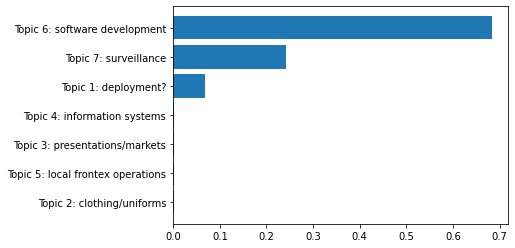

In [245]:
# Sample a random document and print topic
doc_id = np.random.randint(0, len(descriptions["Short description"]) - 1)
print(f"doc_id: {doc_id}")
describe_doc(7)

Topic: 2 - local operational support
Number of documents for this topic: 14

doc_id: 131
Description:
Provision of fuel cards and associated services for Frontex cars operating in Bulgaria.

Topics (ranked):


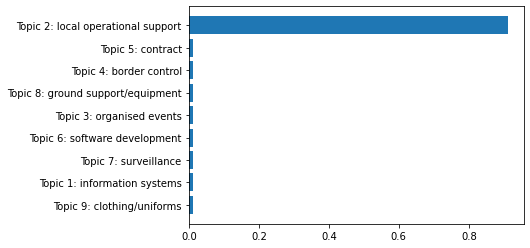

In [14]:
# For a given topic sample a random document
topic_n = 2
print(f"Topic: {topic_n} - {topic_names[topic_n]}")

# all documents with a given topic as dominant topic
topic_docs = [i for i, val in enumerate(data_lda) if np.argsort(val)[-1] == topic_n - 1]
print(f"Number of documents for this topic: {len(topic_docs)}\n")

# a random document of the given topic
for doc_id in random.sample(topic_docs, k=1):
    print(f"doc_id: {doc_id}")
    describe_doc(doc_id, plot=True)
    print("="*80)

## Topic distribution per year

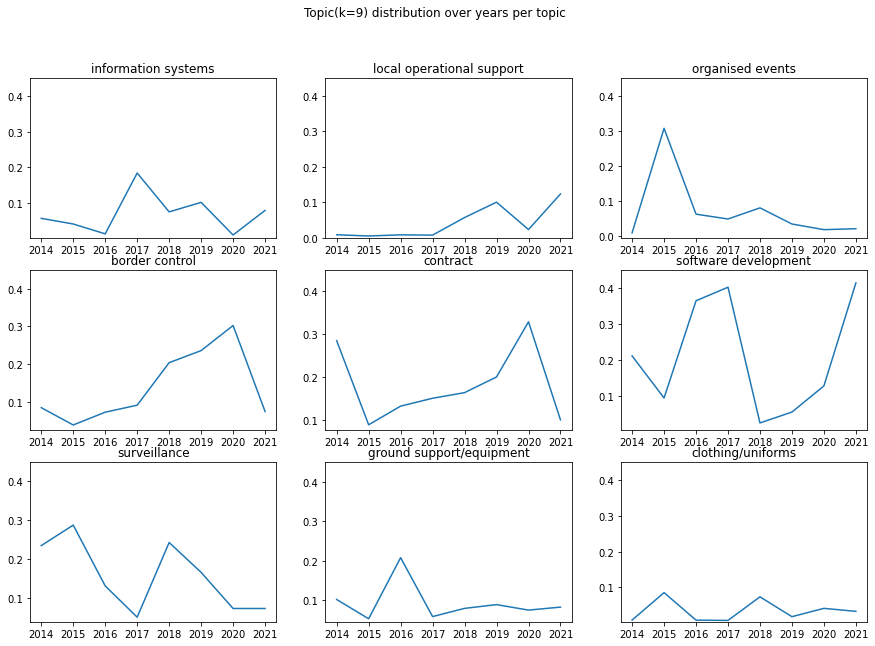

In [93]:
# create topic distribution per year
data = descriptions
topic_dist_years = []
for year in [str(y) for y in range(2014, 2022)]:
    ids = data[data["Notice dispatch date"].str.contains(year)].index
    topic_dist = np.mean(data_lda[ids], axis=0)
    topic_dist_years.append(topic_dist)
    
    
# plot the distribution of each topic over the years
fig = plt.figure(figsize = (15,10))
plt.suptitle("Topic(k=9) distribution over years per topic")
fig.tight_layout(pad=1.0)
for topic_index in range(len(data_lda[0])):
    plt.subplot(3,int(np.ceil(len(data_lda[0])/3)), topic_index+1)
    plt.plot(list(range(2014, 2022)), [x[topic_index] for x in topic_dist_years])
    plt.title(topic_names[topic_index+1])
    plt.ylim(top=0.45)

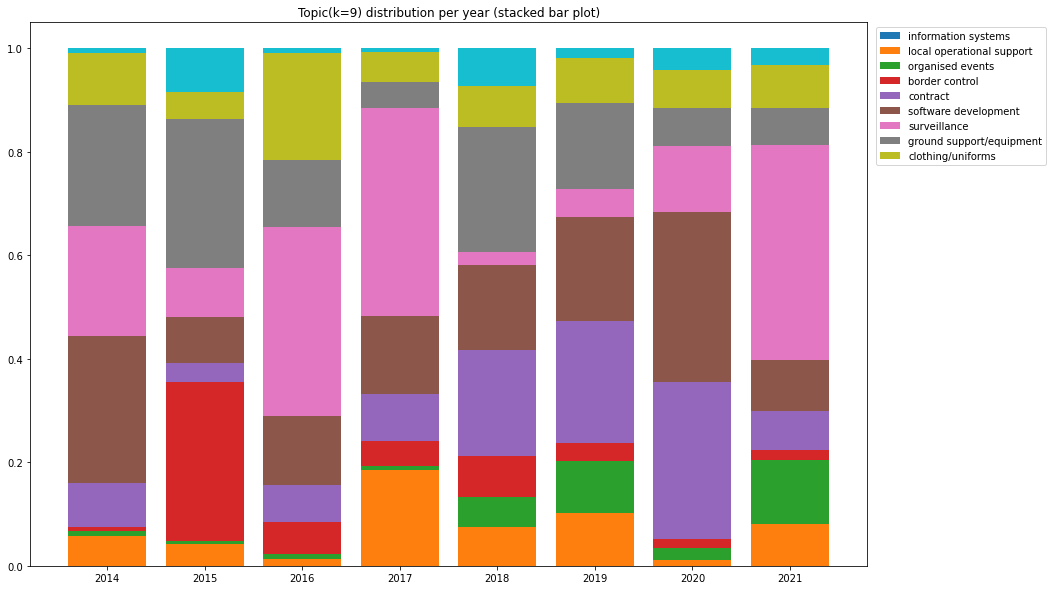

In [97]:
# stacked bar plot for yearly topic distribution
fig = plt.figure(figsize = (15,10))
plt.title("Topic(k=9) distribution per year (stacked bar plot)")
plt.bar(list(range(2014, 2022)), [x[0] for x in topic_dist_years])
for i in range(len(data_lda[0])):
    plt.bar(
        list(range(2014, 2022)),
        [x[i] for x in topic_dist_years], 
        bottom=np.sum([[x[y] for x in topic_dist_years] for y in range(0,i)], axis=0)
    )
plt.legend(topic_names.values(), loc=1, bbox_to_anchor=(1.22, 1))